Тетрадка - вариант решения тестового задания. ТГ для связи: https://t.me/Serge_koval

## Основная часть

Использование встроенного в Open_CV функционала не дало достаточного качества, пришлось использовать внешние библиотеки. Кстати, и распознавание текста из цветного изображения проходит, на мой взгляд, получше, чем ч/б.

In [ ]:
!pip install easyocr

In [ ]:
!pip install mtcnn

В качестве "якорной точки" ориентируемся на наличие фото. Другие элементы в качестве шаблона не очень подходят. Распознать "Российская Федерация" можно только после детекции, - а присутствует не всегда. Проблеммы и с номером по правому борту.

In [ ]:
# cv
import cv2
import PIL
import numpy as np
from mtcnn import MTCNN
import easyocr

# general
import os
import string
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
CURRENT = "current.png"
letters = "".join([chr(x) for x in range(ord('а'), ord('я') + 1)]) + 'ё'
CHARS = letters + letters.upper() + string.digits + '.'
reader = easyocr.Reader(["ru"])
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
detector = MTCNN()

 
class NotFacesFoundError(Exception):
    pass

class NameNotFoundError(Exception):
    pass


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

In [ ]:
# здесь функции, используемые и для демо-части и для пользовательской 

def save_masked(im, mask, filename=CURRENT):
    saved_img = cv2.bitwise_and(im, im, mask=mask)
    cv2.imwrite(filename, saved_img)
    return saved_img


def check_coord(c, tr_h, w_c):
    h, w, x_c = c[3][1] - c[0][1], c[1][0] - c[0][0], (c[0][0] + c[1][0]) / 2
    return (h > 0.8 * tr_h) and (w_c - 2 * w < x_c < w_c + 2 * w)


def get_text_result(textes, tr_conf=0.5):
    res = []
    tr = []  # собираем высоту боксов (ориентируемся на 3 самых высоких), центры по горизонтали

    for coord, text, confidence in textes:
        words = [word.upper() for word in text.split() if word.isalpha()]  # ["WORD_A", "WORD_B"]
        if words and confidence > tr_conf:
            tr.append((coord[3][1] - coord[0][1], (coord[0][0] + coord[1][0]) / 2))
            res.append((coord, words[0]))  # Для этого варианта только 1 слово
    
    if len(res) < 3:
        raise  NameNotFoundError
    
    tr.sort(reverse=True)
    tr_h = tr[2][0] if len(tr) > 2 else sum([h for h, x in tr[:3]]) / 3
    w = [x_c for h, x_c in tr]
    w.sort()
    w_c = sum(w[:3]) / 3

    res = [pair for pair in res if check_coord(pair[0], tr_h, w_c)]    # отбросили те, что ниже порога
    res = sorted(sorted(res, key=lambda pair: pair[0][0][0]), key=lambda pair: pair[0][0][1])   # "Y" по возрастанию ("Х" по возрастанию)

    keys = ("Фамилия", "Имя", "Отчество")
    answer = {key: val[-1] for key, val in zip(keys, res)}
    if len(answer) == 3:
        return answer
    raise NameNotFoundError


def get_faces_coord_cnn(im_colored, x_min, y_min, x_max, y_max):
    " MTCNN coord , - возвращаем 1 box"
    res = detector.detect_faces(im_colored)
    boxes = [item.get('box') for item in res]
    if boxes:
        return boxes[0]
 
    raise NotFacesFoundError(boxes, x_min, y_min, x_max, y_max)


def get_mask(shape, x1, y1, x2, y2):
    mask = np.zeros(shape[:2], np.uint8)
    cv2.rectangle(mask, pt1=(x1, y1), pt2=(x2, y2), color=255, thickness=-1)
    return mask


def erose_border(img):
    corners = np.uint0(cv2.goodFeaturesToTrack(img, 20, 0.05, 200))
    x_min, y_min = img.shape
    x_max, y_max = 0, 0
    for corner in corners:
        x, y = corner.ravel()
        x_min, y_min = min(x_min, x), min(y_min, y)
        x_max, y_max = max(x_max, x), max(y_max, y)

    mask = get_mask(img.shape, x_min, y_min, x_max, y_max)
    img = cv2.bitwise_and(img, img, mask=mask)

    return img, (x_min, y_min, x_max, y_max)


def save_crop_text(im, x, y, w, h, filename, denoiser=None):
    # рассчет координат для окна с ФИО"
    x1, y1 = x + int(1.9 * w), y - int(1.29 * h)
    x2, y2 = x + int(7.6 * w), y + h - int(0.33 * h)
    if denoiser:
        pass
        # маскирование фото
        mask1 = get_mask(im.shape, int(x - 0.2 * w), int(y - 0.2 * h), int(x + 1.2 * w), int(y + 1.2 * h)) 
        im = cv2.bitwise_or(im, im, mask=mask1)
        im = denoiser(im)

    mask2 = get_mask(im.shape[:2], x1, y1, x2, y2)  
    return save_masked(im, mask2, filename)


def best_ocr(temp_file):
    text = reader.readtext(temp_file, 
                           decoder='beamsearch', 
                           contrast_ths=0.25, 
                           allowlist=CHARS,           # возможно ведет к переобучению
                           min_size=15)
    return text


def convert_image2text(image_file, temp_file=CURRENT, ocr_func=best_ocr):
    img_c = cv2.imread(image_file)
    img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)   # на цветном даже лучше не только фото искать, но и OCR отрабатывает хорошо.
    img = cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY)

    #  Определим точки внешнего контура,- не дать внешнему контуру внести смещение в denoising
    img, (x_min, y_min, x_max, y_max) = erose_border(img)

    # фотография будет служить привязкой для окна, в котором ищем ФИО
    x, y, w, h = get_faces_coord_cnn(img_c, x_min, y_min, x_max, y_max)   # NotFacesFoundError!!
    cv2.rectangle(img, (x, y), (x + w, y + h), 0, 3)

    # выделяем и сохраняем целевой сегмент
    cropp = save_crop_text(img_c, x, y, w, h, filename=temp_file, denoiser=None)

    text = ocr_func(temp_file)
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 18))
    ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(cropp, cmap='gray', vmin=0, vmax=255)
    plt.show()

    return text


## Эта часть относится к боту,- раз просили API.
И поскольку цели чисто тестовые - самая простая из библиотек.

In [ ]:
!pip install pytelegrambotapi

In [ ]:
from io import BytesIO
from telebot import types
from telebot import TeleBot
import requests
from telebot import apihelper
import logging
from tele_token import  TOKEN     # файл с токеном



def store_photo_id(bot, message, image_files):
    # нужно получить  картинки, поэтому будем сохранять id  картинки в словарь
    chat_id = message.chat.id
    # получаем информацию о картинке , сохраняем photo_Id   за пользователем
    image_id = message.photo[-1].file_id
    print('Obtained file_obj = ', image_id)
    image_files[chat_id] = image_id
    

def save_photo(bot, image_id, file_name):
    image_file_obj = bot.get_file(image_id)
    image_file = bot.download_file(image_file_obj.file_path)

    # bytes переводим в Image и далее в тензор
    image_file = BytesIO(image_file)
    image_file.seek(0)
    image = PIL.Image.open(image_file)
    print("image_shape", image.size)
    image.save(file_name)


def main_bot():
    image_files = {}  
    logging.basicConfig(
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        level=logging.INFO)

    bot = TeleBot(TOKEN)
    command = "прочитать ФИО по скану"

    markup_menu = types.ReplyKeyboardMarkup(resize_keyboard=True, row_width=3)  
    markup_menu.add(types.KeyboardButton(command))


    @bot.message_handler(commands=['start', 'help'])
    def send_welcome(message: types.Message):
        text = ""
        if message.text == "/start":
            text = "У бота только одна опция: прочитать ФИО по скану паспорта"
        elif message.text == "/help":
            text = "простой последовательный бот для парсинга ФИО"
        bot.send_message(message.chat.id, text, reply_markup=markup_menu) 
            

    @bot.message_handler(content_types=['photo'])
    def photo(message):
        store_photo_id(bot, message, image_files)


    @bot.message_handler(func=lambda message: True)
    def send_welcome(message: types.Message):
        text_template = "отправьте скан паспорта, страница с текстом должна располагаться горизонтально"
        chat_id = message.chat.id
        file_name = str(chat_id) + ".png"

        if message.text == command:
            if chat_id in image_files:
                bot.send_message(chat_id, 
                                     "Файл получен, обработка займет несколько минут",
                                     reply_markup=markup_menu
                                    )
                try:
                    save_photo(bot, image_files[chat_id], file_name)
                    texts = convert_image2text(file_name) 
                    answer = get_text_result(texts)  
                    print("OK! answer=", answer) 
                    text = "\n".join([f"{key}: {val}" for key, val in answer.items()])
                    bot.send_message(chat_id, 
                                     text,
                                     reply_markup=markup_menu
                                    )
                except NotFacesFoundError:
                    bot.send_message(chat_id, 
                                     "Возможно это скан, и даже скан паспорта, но бот не смог его распознать\n" + text_template,
                                     reply_markup=markup_menu
                                    )
                except NameNotFoundError as e:
                    print("NameNotFoundError <> file_name, texts:", file_name, texts)
            else:
                bot.send_message(chat_id, 
                                 "Сначала " + text_template,
                                 reply_markup=markup_menu
                                )
        else:
            bot.send_message(chat_id, 
                                f'{message.text} -что это было???',
                                reply_markup=markup_menu
                                )

    bot.polling(none_stop=True, timeout=60)

Запускать бота здесь (раскомментировать):

In [ ]:
# main_bot()

## Демо- часть.

Пример обработки тестовых сканов. Не все читаются хорошо. В примере понизил порог уверенности до 0.3, но правильнее говорить "Не знаю" при большем пороге . Также есть сомнение в полезности allow_list - возможно достовернее было бы избежать подгонки и отбрасывать не литеральные ответы.

In [ ]:
filenames = []
for filename in sorted(os.listdir(os.getcwd())):
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        filenames.append(filename)
", ".join(filenames)

'0.jpeg, 1.jpeg, 2.jpeg, 3.jpeg, 4.png, 5.jpeg, 6.jpeg, 7.jpeg, 8.jpeg, 9.jpeg'

1/1 [==============================] - 0s 36ms/step


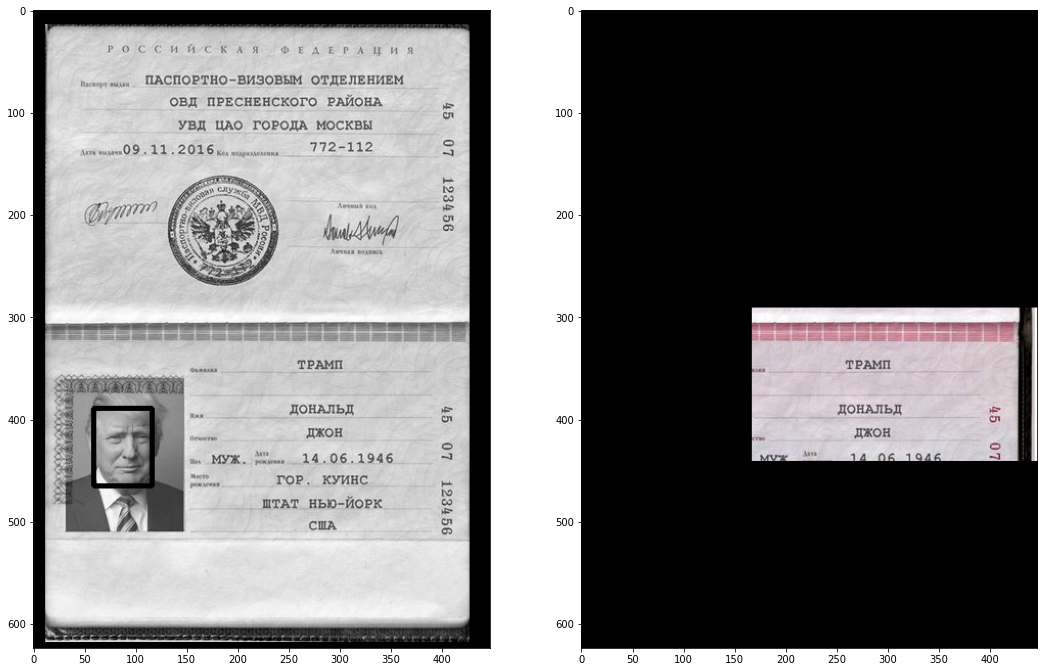

OK! answer= {'Фамилия': 'ТРАМП', 'Имя': 'ДОНАЛЬД', 'Отчество': 'ДЖОН'}
----------------------------------------
1/1 [==============================] - 0s 32ms/step


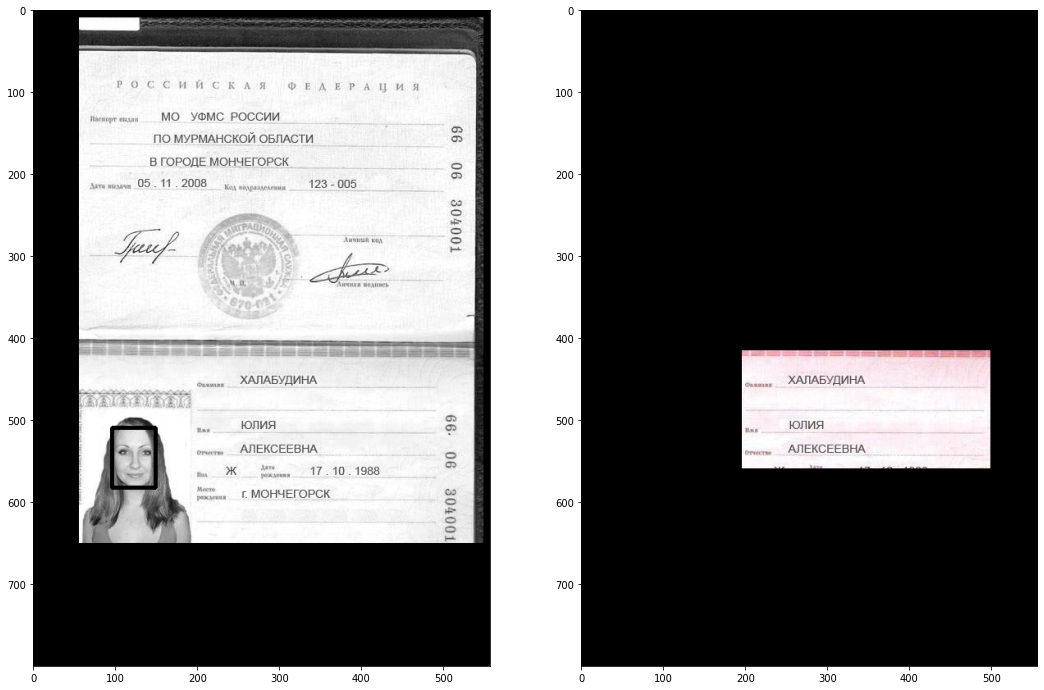

OK! answer= {'Фамилия': 'ХАЛАБУДИНА', 'Имя': 'ЮЛИЯ', 'Отчество': 'АЛЕКСЕЕВНА'}
----------------------------------------
1/1 [==============================] - 0s 35ms/step


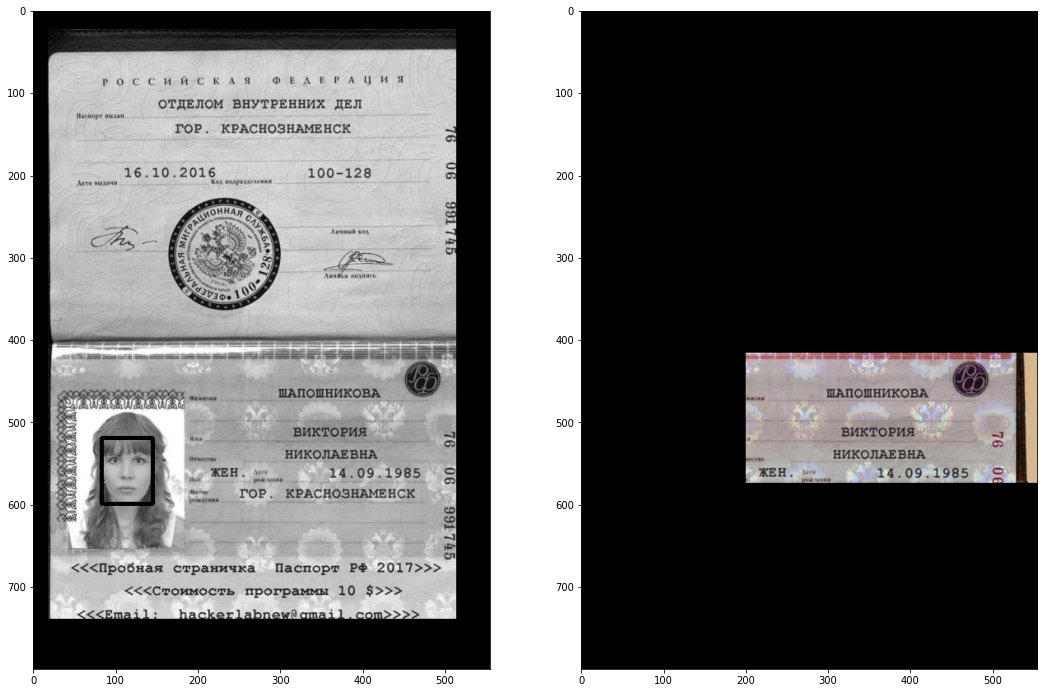

OK! answer= {'Фамилия': 'ШАПОШНИКОВА', 'Имя': 'ВИКТОРИЯ', 'Отчество': 'НИКОЛАЕВНА'}
----------------------------------------
1/1 [==============================] - 0s 29ms/step


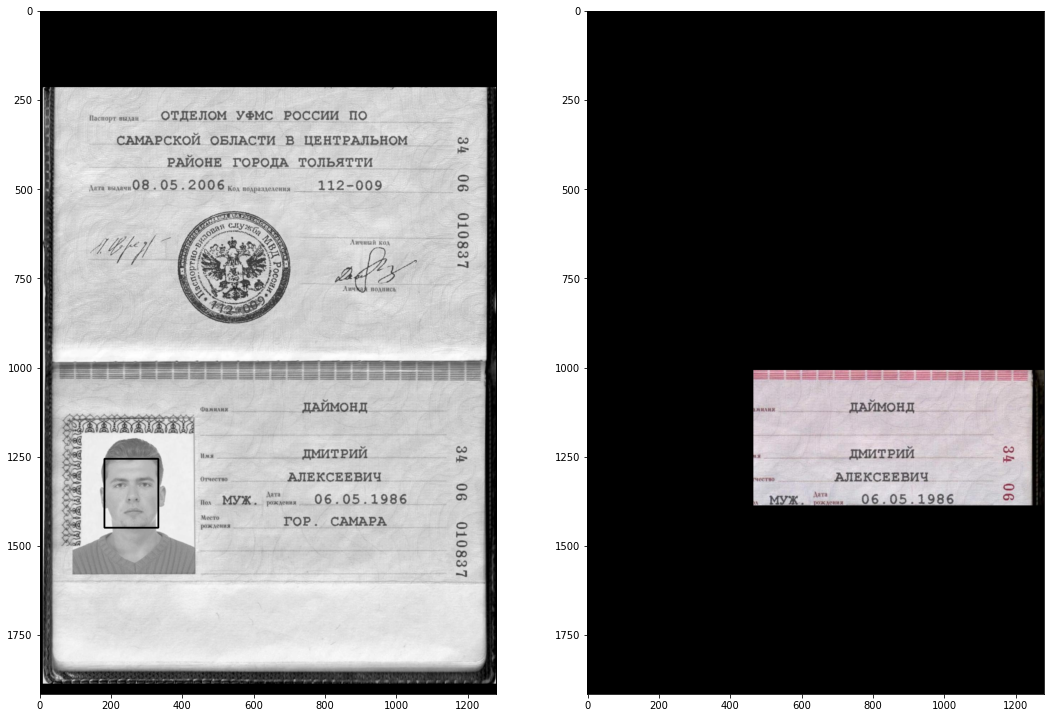

OK! answer= {'Фамилия': 'ДАЙМОНД', 'Имя': 'ДМИТРИЙ', 'Отчество': 'АЛЕКСЕЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 28ms/step


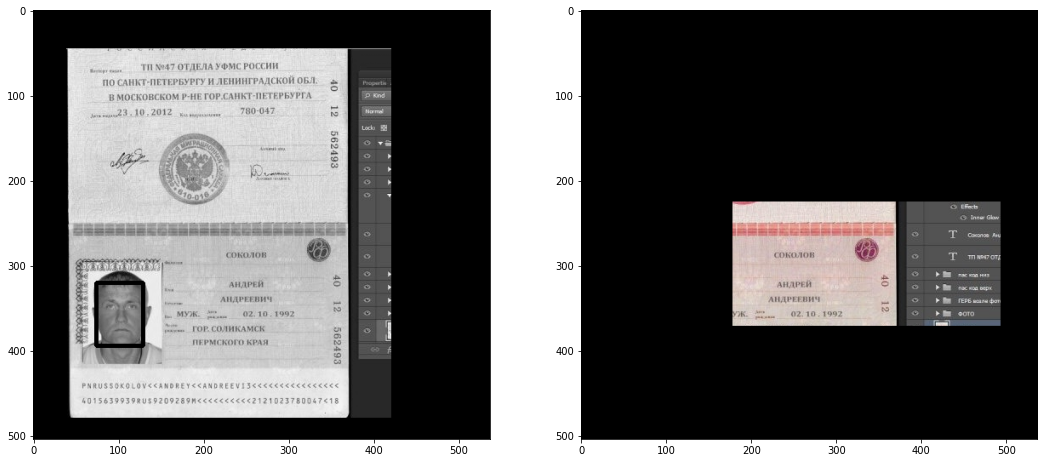

OK! answer= {'Фамилия': 'СОКОЛОВ', 'Имя': 'АНДРЕИ', 'Отчество': 'АНДРЕЕНИЧ'}
----------------------------------------
1/1 [==============================] - 0s 28ms/step


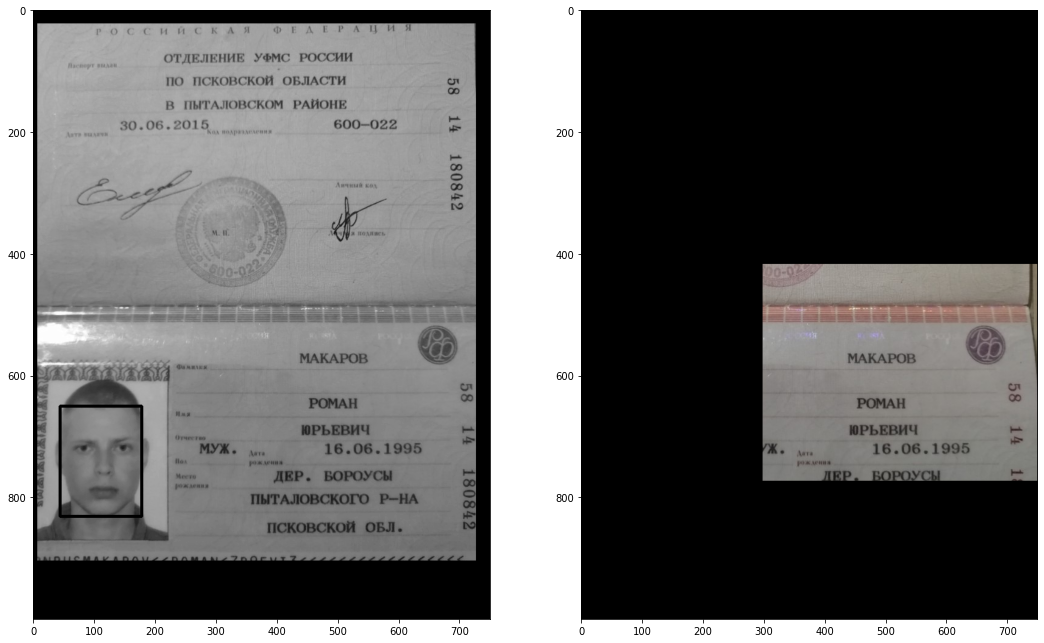

OK! answer= {'Фамилия': 'МАКАРОВ', 'Имя': 'РОМАН', 'Отчество': 'ЮРЬЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 40ms/step


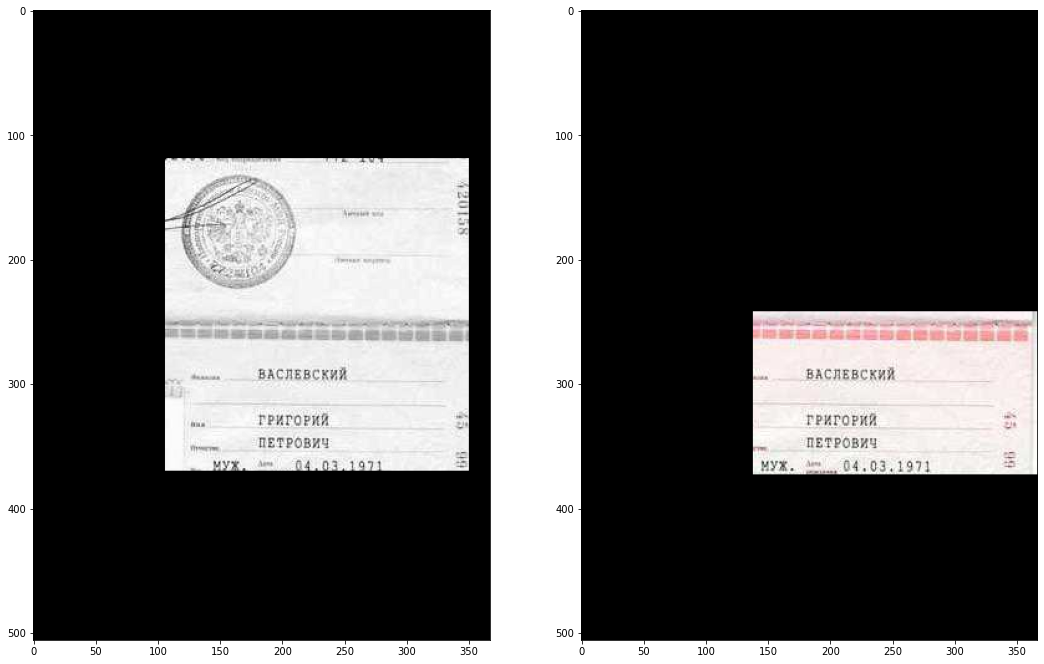

OK! answer= {'Фамилия': 'ВАСЛЕВСКИЯ', 'Имя': 'ГРКГОРЖЯ', 'Отчество': 'ПЕТРОВИЦ'}
----------------------------------------
1/1 [==============================] - 0s 49ms/step


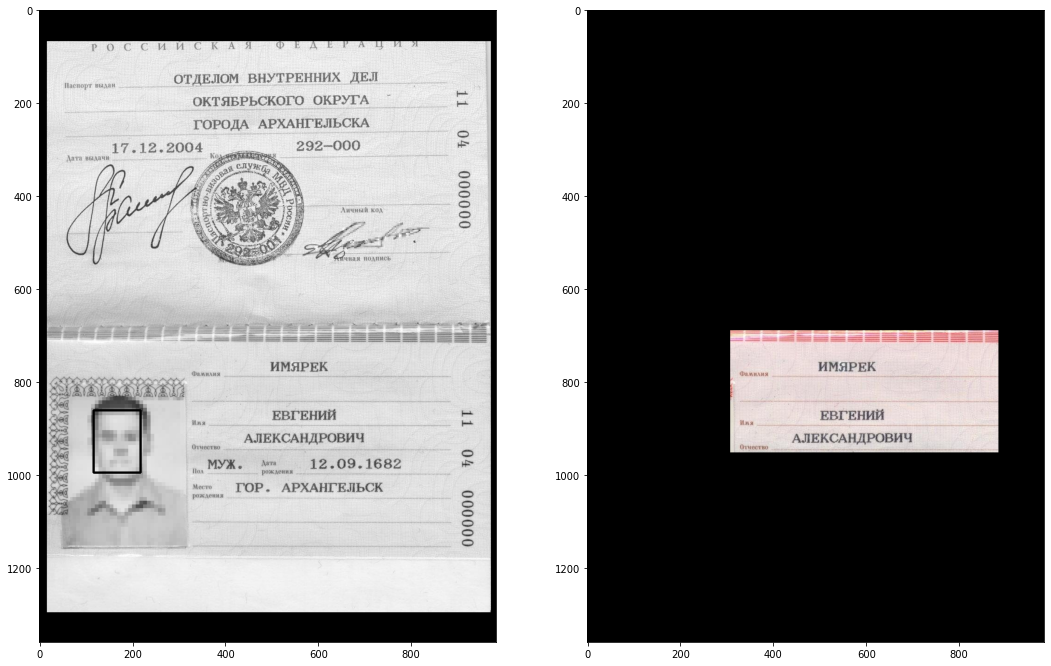

OK! answer= {'Фамилия': 'ИМЯРЕК', 'Имя': 'ЕВГЕНИЙ', 'Отчество': 'АЛЕКСАНДРОВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 37ms/step


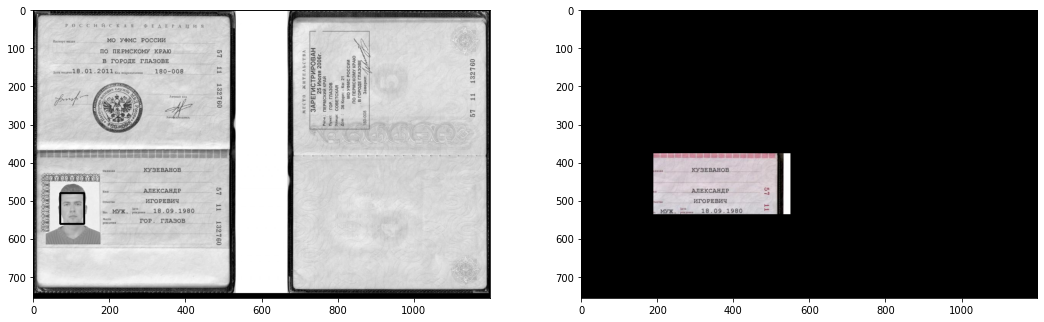

OK! answer= {'Фамилия': 'КУЗЕВАНОВ', 'Имя': 'АЛЕКСАНДР', 'Отчество': 'ИГОРЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 58ms/step


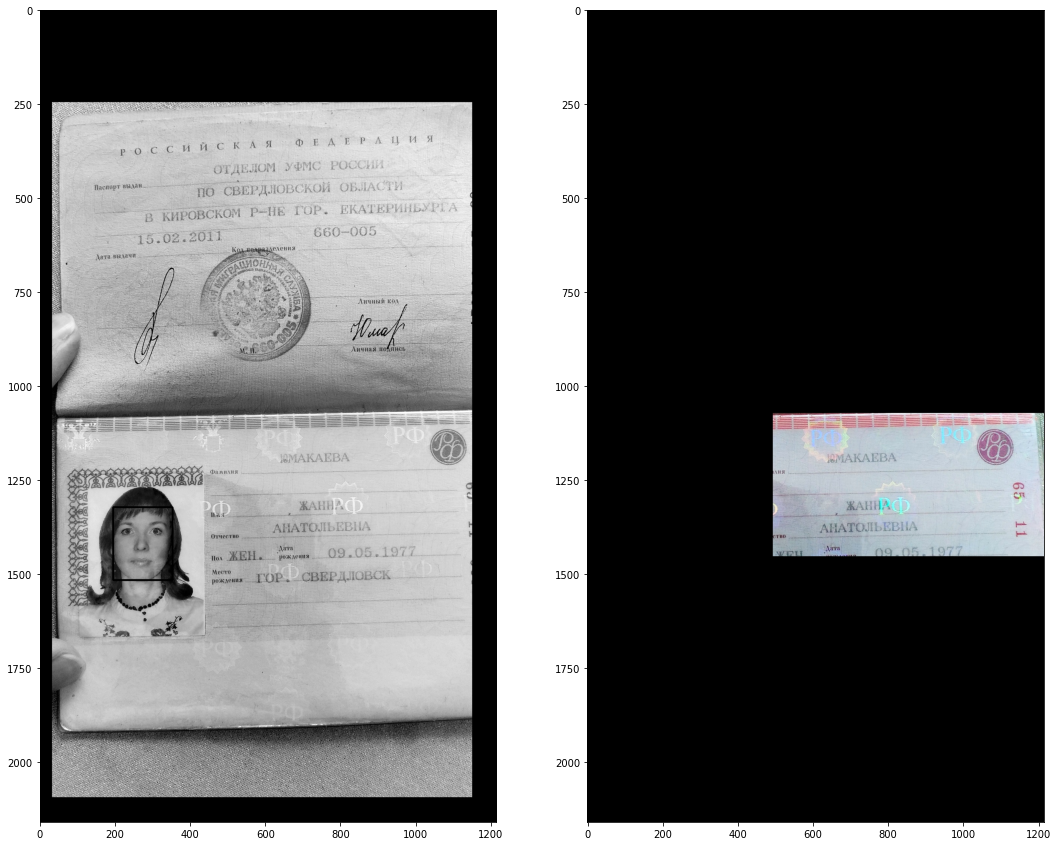

NameNotFoundError <> file_name, texts: 9.jpeg [([[589, 1109], [682, 1109], [682, 1170], [589, 1170]], '5а', 0.018480074415621446), ([[934, 1104], [1028, 1104], [1028, 1160], [934, 1160]], 'РФ', 0.9998688415268309), ([[629, 1173], [827, 1173], [827, 1209], [629, 1209]], 'ЗМАКАЕВА', 0.248599807484206), ([[497, 1223], [529, 1223], [529, 1237], [497, 1237]], 'лия', 0.9264630048042338), ([[1127, 1251], [1167, 1251], [1167, 1307], [1127, 1307]], 'с', 0.8324159104233786), ([[685, 1301], [777, 1301], [777, 1337], [685, 1337]], 'ЖАНН', 0.32086890935897827), ([[768, 1290], [866, 1290], [866, 1346], [768, 1346]], 'РРФ', 0.9841076592361885), ([[616, 1355], [883, 1355], [883, 1397], [616, 1397]], 'АНАТОЛЬЕВНА', 0.9804577381277528), ([[1135, 1353], [1173, 1353], [1173, 1407], [1135, 1407]], '6', 0.2684134907234501), ([[501, 1395], [531, 1395], [531, 1407], [501, 1407]], 'ТНО', 0.39160811318710864), ([[633, 1423], [675, 1423], [675, 1443], [633, 1443]], 'Дата', 0.9490910768508911), ([[830, 1423], [88

In [ ]:
for file_name in filenames:   
    try:
        texts = convert_image2text(file_name) 
        answer = get_text_result(texts, tr_conf=0.3)  
        print("OK! answer=", answer) 
    except NotFacesFoundError:
        print("Not found face --> aborted")
    except NameNotFoundError as e:
        print("NameNotFoundError <> file_name, texts:", file_name, texts)
    print("--" * 20)

Паспорта Васлевского, Юмакаевой и Соколова читаются плохо, с ошибками. Но порог уверенности модели в этом демонстрационном примере поставлен низким(0.3) - поэтому ошибка выскакивает только на Юмакаевой, остальные 2  прочитаны с опечатками.

In [ ]:
3-ю часть не успеваю - все что к ней относилось удалил в копии. По факту я только загрузчик писать буду пару часов, а с учетом несбалансированности классов, сосмневаюсь, что и это стоит делать, т.к., 
похоже, результат будет не очень. Поэтому выкладываю копию, чтобы не создавалось  впечатление, что тестовое проигнорировал.